In [20]:
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
import seaborn as sns
import pandas as pd
from scipy.stats import norm

In [91]:
def var_analysis(df_list, conf_level, usd_balance, positions, occurance_data=1000):

    usd_in_position = 0
    returns = pd.DataFrame()
    for pair in list(positions.keys()):
        usd_in_position += positions[pair]["long"] + positions[pair]["short"]
        temp_df = df_list[pair].copy()

        returns["long_"+pair] = temp_df["close"].pct_change()
        returns["short_"+pair] = -temp_df["close"].pct_change()
        
    if usd_in_position == 0:
        return [0] * 150
    
    weights = []   
    for pair in list(positions.keys()):
        weights.append(positions[pair]["long"] / usd_in_position)
        weights.append(positions[pair]["short"] / usd_in_position)

    weights = np.array(weights)
    #print(weights)
    # Generate Var-Cov matrix

    cov_matrix = returns.cov()

    # Calculate mean returns for each stock
    avg_rets = returns.mean()

    # Calculate mean returns for portfolio overall, 
    # using dot product to 
    # normalize individual means against investment weights
    port_mean = avg_rets.dot(weights)

    # Calculate portfolio standard deviation
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    # Calculate mean of investment
    mean_investment = (1+port_mean) * usd_in_position

    # Calculate standard deviation of investmnet
    stdev_investment = usd_in_position * port_stdev

    # Using SciPy ppf method to generate values for the
    # inverse cumulative distribution function to a normal distribution
    # Plugging in the mean, standard deviation of our portfolio
    # as calculated above
    cutoff1 = norm.ppf(conf_level, mean_investment, stdev_investment)

    #Finally, we can calculate the VaR at our confidence interval
    var_1d1 = usd_in_position - cutoff1
    
    print(f"USD Balance: {usd_balance}$")
    print(f"USD in Position: {usd_in_position}$")
    print(f"Value at Risk 1 period: {round(var_1d1, 2)}$ ~ {round(var_1d1 / usd_balance * 100, 2)}%")

    # Calculate n Period VaR
    var_array = []
    num_periods = int(150)
    for x in range(1, num_periods+1):    
        var_array.append(np.round(var_1d1 * np.sqrt(x),2))

    print(f"Value at Risk 24 periods: {round(var_array[24], 2)}$ ~ {round(var_array[24] / usd_balance * 100, 2)}%")
    print(f"Value at Risk 100 periods: {round(var_array[100], 2)}$ ~ {round(var_array[100] / usd_balance * 100, 2)}%")

    # Build plot
    plt.xlabel("Period #")
    plt.ylabel("Max portfolio loss (USD)")
    plt.title(f"Max portfolio loss (VaR) over {num_periods} periods")
    plt.plot(var_array, "r")
    plt.show()
    
    return cov_matrix

In [92]:
usd_balance = 1000

occurance_data = 10000
conf_level = 0.05

positions = {
    "BTC-USDT":{"long":400,"short":0},
    "ETH-USDT":{"long":200,"short":0},
    "BNB-USDT":{"long":0,"short":0},
    "LINK-USDT":{"long":0,"short":0},
    "SOL-USDT": {"long": 0, "short": 0},
}


df_list = {}

for pair in positions.keys():
    df = pd.read_csv(pair+".csv") 
    df_list[pair] = df

df_list["LINK-USDT"]

,date,open,high,low,close,volume
0,1547632800000,0.5355,0.5355,0.5003,0.5066,63365.33
1,1547636400000,0.5146,0.5162,0.4980,0.4980,153229.70
2,1547640000000,0.4980,0.5021,0.4836,0.4887,185102.78
3,1547643600000,0.4887,0.4973,0.4869,0.4869,67053.33
4,1547647200000,0.4914,0.4920,0.4668,0.4746,168009.30
...,...,...,...,...,...,...
53366,1739966400000,18.1200,18.1600,17.9200,17.9300,120699.71
53367,1739970000000,17.9300,18.1800,17.9300,18.0800,136630.84
53368,1739973600000,18.0800,18.2100,17.8200,17.8400,222364.15
53369,1739977200000,17.8400,17.9900,17.7400,17.8000,160016.47


USD Balance: 1000$
USD in Position: 600$
Value at Risk 1 period: 8.18$ ~ 0.82%
Value at Risk 24 periods: 40.9$ ~ 4.09%
Value at Risk 100 periods: 82.21$ ~ 8.22%


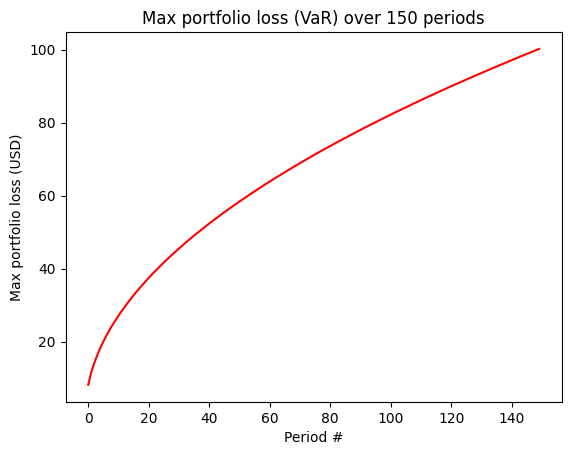

In [93]:
var0 = var_analysis(
    df_list=df_list,
    conf_level=conf_level,
    usd_balance=usd_balance,
    positions=positions,
    occurance_data=occurance_data
)

USD Balance: 1000$
USD in Position: 700$
Value at Risk 1 period: 8.52$ ~ 0.85%
Value at Risk 24 periods: 42.59$ ~ 4.26%
Value at Risk 100 periods: 85.61$ ~ 8.56%


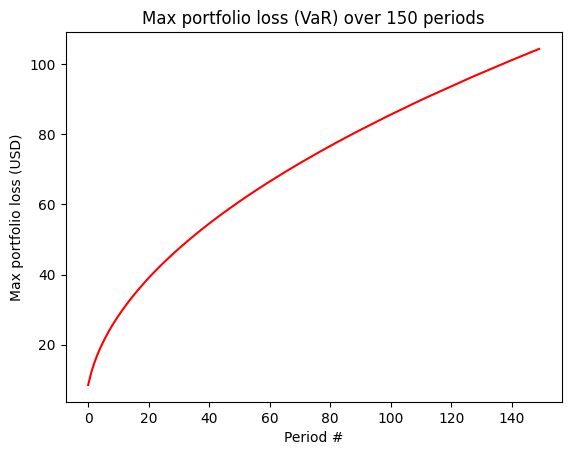

In [73]:
new_position = {"pair":"SOL-USDT", "long": 0, "short": 100}
positions[new_position["pair"]]["long"] += new_position["long"]
positions[new_position["pair"]]["short"] += new_position["short"]

# position_to_analyse = "BTC/USDT"
# positions[position_to_analyse]["long"] = 0
# positions[position_to_analyse]["short"] = 0

var1 = var_analysis(
    df_list=df_list,
    conf_level=conf_level,
    usd_balance=usd_balance,
    positions = positions,
    occurance_data=occurance_data,
)

In [94]:
var0

,long_BTC-USDT,short_BTC-USDT,long_ETH-USDT,short_ETH-USDT,long_BNB-USDT,short_BNB-USDT,long_LINK-USDT,short_LINK-USDT,long_SOL-USDT,short_SOL-USDT
long_BTC-USDT,6.643132e-05,-6.643132e-05,6.516743e-05,-6.516743e-05,-1.437105e-07,1.437105e-07,-1.707375e-07,1.707375e-07,2.002802e-07,-2.002802e-07
short_BTC-USDT,-6.643132e-05,6.643132e-05,-6.516743e-05,6.516743e-05,1.437105e-07,-1.437105e-07,1.707375e-07,-1.707375e-07,-2.002802e-07,2.002802e-07
long_ETH-USDT,6.516743e-05,-6.516743e-05,9.926039e-05,-9.926039e-05,-3.097983e-07,3.097983e-07,-5.172928e-08,5.172928e-08,8.794518e-08,-8.794518e-08
short_ETH-USDT,-6.516743e-05,6.516743e-05,-9.926039e-05,9.926039e-05,3.097983e-07,-3.097983e-07,5.172928e-08,-5.172928e-08,-8.794518e-08,8.794518e-08
long_BNB-USDT,-1.437105e-07,1.437105e-07,-3.097983e-07,3.097983e-07,1.265781e-04,-1.265781e-04,3.785325e-07,-3.785325e-07,-5.796576e-07,5.796576e-07
short_BNB-USDT,1.437105e-07,-1.437105e-07,3.097983e-07,-3.097983e-07,-1.265781e-04,1.265781e-04,-3.785325e-07,3.785325e-07,5.796576e-07,-5.796576e-07
long_LINK-USDT,-1.707375e-07,1.707375e-07,-5.172928e-08,5.172928e-08,3.785325e-07,-3.785325e-07,1.612401e-04,-1.612401e-04,-7.108523e-07,7.108523e-07
short_LINK-USDT,1.707375e-07,-1.707375e-07,5.172928e-08,-5.172928e-08,-3.785325e-07,3.785325e-07,-1.612401e-04,1.612401e-04,7.108523e-07,-7.108523e-07
long_SOL-USDT,2.002802e-07,-2.002802e-07,8.794518e-08,-8.794518e-08,-5.796576e-07,5.796576e-07,-7.108523e-07,7.108523e-07,1.996364e-04,-1.996364e-04
short_SOL-USDT,-2.002802e-07,2.002802e-07,-8.794518e-08,8.794518e-08,5.796576e-07,-5.796576e-07,7.108523e-07,-7.108523e-07,-1.996364e-04,1.996364e-04


In [95]:
var1

,long_BTC-USDT,short_BTC-USDT,long_ETH-USDT,short_ETH-USDT,long_BNB-USDT,short_BNB-USDT,long_LINK-USDT,short_LINK-USDT,long_SOL-USDT,short_SOL-USDT
long_BTC-USDT,6.643132e-05,-6.643132e-05,6.516743e-05,-6.516743e-05,-1.437105e-07,1.437105e-07,-1.707375e-07,1.707375e-07,2.002802e-07,-2.002802e-07
short_BTC-USDT,-6.643132e-05,6.643132e-05,-6.516743e-05,6.516743e-05,1.437105e-07,-1.437105e-07,1.707375e-07,-1.707375e-07,-2.002802e-07,2.002802e-07
long_ETH-USDT,6.516743e-05,-6.516743e-05,9.926039e-05,-9.926039e-05,-3.097983e-07,3.097983e-07,-5.172928e-08,5.172928e-08,8.794518e-08,-8.794518e-08
short_ETH-USDT,-6.516743e-05,6.516743e-05,-9.926039e-05,9.926039e-05,3.097983e-07,-3.097983e-07,5.172928e-08,-5.172928e-08,-8.794518e-08,8.794518e-08
long_BNB-USDT,-1.437105e-07,1.437105e-07,-3.097983e-07,3.097983e-07,1.265781e-04,-1.265781e-04,3.785325e-07,-3.785325e-07,-5.796576e-07,5.796576e-07
short_BNB-USDT,1.437105e-07,-1.437105e-07,3.097983e-07,-3.097983e-07,-1.265781e-04,1.265781e-04,-3.785325e-07,3.785325e-07,5.796576e-07,-5.796576e-07
long_LINK-USDT,-1.707375e-07,1.707375e-07,-5.172928e-08,5.172928e-08,3.785325e-07,-3.785325e-07,1.612401e-04,-1.612401e-04,-7.108523e-07,7.108523e-07
short_LINK-USDT,1.707375e-07,-1.707375e-07,5.172928e-08,-5.172928e-08,-3.785325e-07,3.785325e-07,-1.612401e-04,1.612401e-04,7.108523e-07,-7.108523e-07
long_SOL-USDT,2.002802e-07,-2.002802e-07,8.794518e-08,-8.794518e-08,-5.796576e-07,5.796576e-07,-7.108523e-07,7.108523e-07,1.996364e-04,-1.996364e-04
short_SOL-USDT,-2.002802e-07,2.002802e-07,-8.794518e-08,8.794518e-08,5.796576e-07,-5.796576e-07,7.108523e-07,-7.108523e-07,-1.996364e-04,1.996364e-04
